In [158]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Необходимые Функции
Набор custom функций для решения задачи

In [127]:
def get_cross_table(df: pd.DataFrame, x: str, y: str) -> tuple:
    cross_tab_a = pd.crosstab(df[x], df[y]).T
    cross_tab_b = df.groupby([x])[y].agg([np.mean]).sort_values(by="mean", ascending=False).T
    return cross_tab_a, cross_tab_b

def remove_outliers(X, threshold=3.0):
    z_scores = np.abs(stats.zscore(X, nan_policy='omit'))
    return X[(z_scores < threshold).all(axis=1)]


outlier_remover = FunctionTransformer(remove_outliers, validate=False)

### Описание Задачи
Это набор данных HR. Задача состоит в том, чтобы проверить, получил ли сотрудник повышение или нет.
Названия колонок:
- employee_id
- department
- region
- education
- gender
- recruitment_channel
- nooftrainings
- age
- previousyearrating
- lengthofservice
- KPIs_met >80%
- awards_won?
- avgtrainingscore
- is_promoted

### Загрузка Данных
Загрузим и предварительно взглянем на данные

In [5]:
data = pd.read_csv('dataset.csv')
data

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


- Узнаем есть ли пропуски в данных

In [21]:
data.isna().sum() / data.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

Признаки `education` и `previous_year_rating` имеют небольшое число пропусков. Для отправного baseline решения мы просто удалим строки с NaN. Однако хорошо было бы проверить неслучайны эти пропуски. Также, для улучшения baseline, можно будет попробовать заполнить их статистиками (среднее, медиана). Также стоить отметить, что заполнения пропусков стоит производить после разбиения на `train/test`

**Распределение Целевого Класса**

Скорее всего мы будем иметь дело с несбалансированными данными (положительного класса - 1, значительно меньше отрицательного - 0)

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64


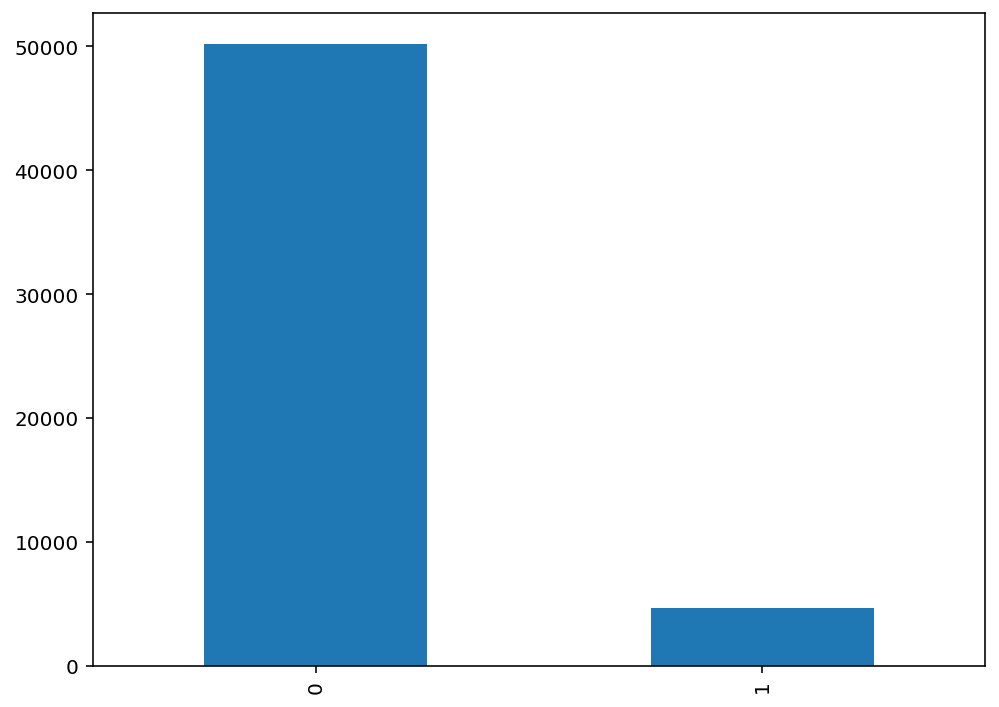

In [47]:
plt.figure(figsize=(8,6))

print(data['is_promoted'].value_counts(normalize=True)*100)
data['is_promoted'].value_counts().plot(kind='bar')
plt.show()

- Целевого класса всего 8.5%, значительный дисбаланс который будет влиять на качество модели. Поэтому будем использовать метрики для несбалансированных выборок: precision, recall, f1, roc-auc.
- Можно в дальнейшем использовать различные техники для борьбы с дисбалансом -> undersampling и oversampling. Но для baseline достаточно просто использование гиперпараметра `class_weights` где укажем больший вес положительного класса.

### Exploratory Data Analysis / EDA
Проведем EDA для проверки взаимосвязей фичей с таргетом. Так как наш таргет бинарный, то для EDA посмотрим на распределения и BoxPlot в разрезе классов + можно использовать пару методов, определяющие корреляцию между непрерывными переменными и бинарной (point-biserial correlation). Это предварительный анализ, мы не будем усложнять все сразу и нарушать золотое правило 80 на 20 (Парето). 

Первоначальная цель - получить простой, но стабильный бейзлайн.

In [48]:
# удалим пропуски из данных для EDA
data_eda = data.dropna()

#### Department Feature
Департамент сотрудника

Sales & Marketing    14239
Operations           10547
Procurement           6641
Technology            6502
Analytics             4610
Finance               2219
HR                    2142
R&D                    893
Legal                  867
Name: department, dtype: int64


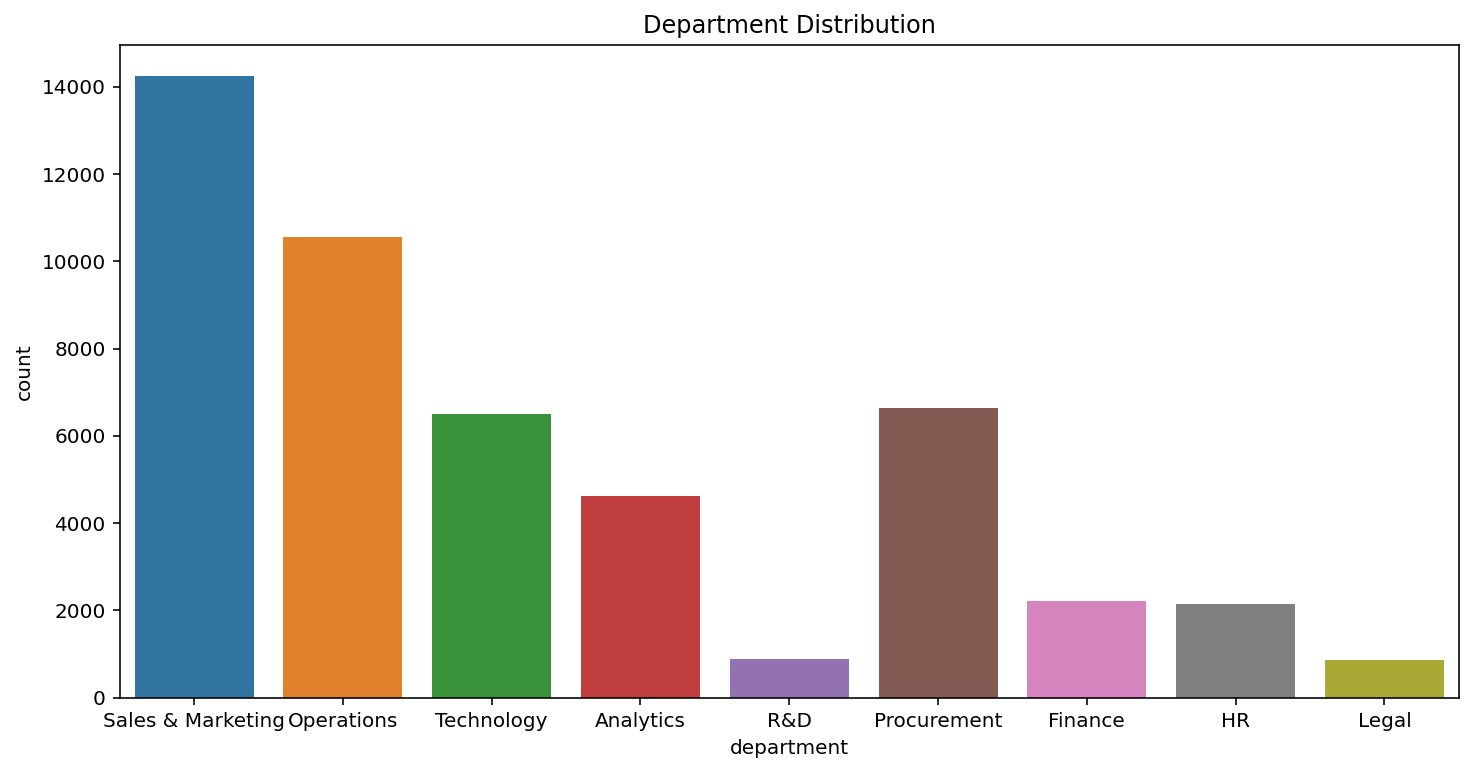

In [54]:
plt.figure(figsize=(12, 6))
print(data_eda['department'].value_counts())
plt.title('Department Distribution')
sns.countplot(data_eda['department'])
plt.show()

- Большинство сотрудников из `Sales & Marketing` и `Operations`, меньше всего из `R&D` и `Legal`

Теперь рассмотрим в разрезе таргета

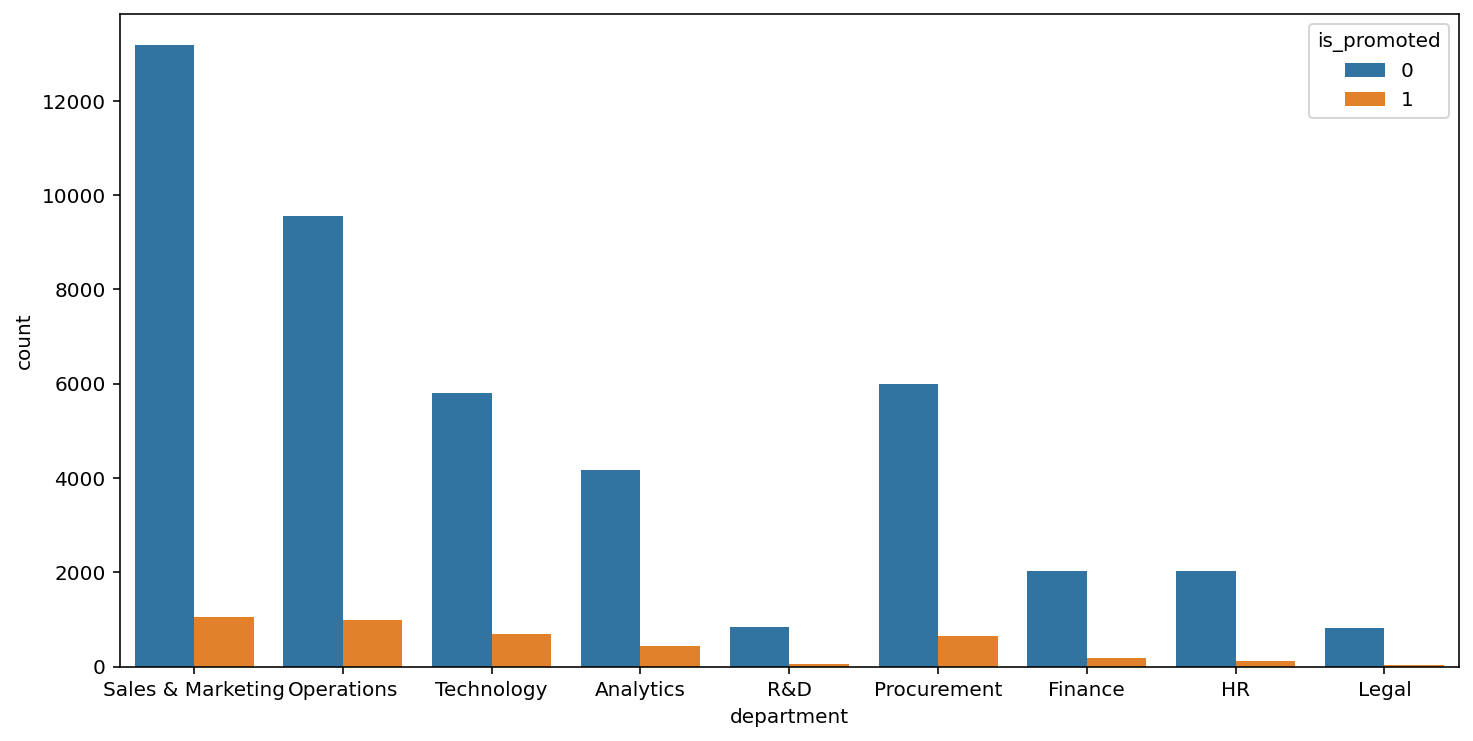

In [55]:
plt.figure(figsize=(12, 6))
sns.countplot(x="department", hue="is_promoted", data=data_eda);

- По гистограмме кажется, что обычно повышение получали в таких епартаментах как `Sales & Marketing`, `Operations`, `Technology`
- Меньше всего людей из `R&D`, `HR` и `Finance`

Взглянем на кросс-таблицу -> посмотрим как таргет меняется по категориям и в какой категории его еффек сильнее всего

In [60]:
department_cross_tab_a, department_cross_tab_b = get_cross_table(df=data_eda, x='department', y='is_promoted')
department_cross_tab_a

department,Analytics,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
is_promoted,,,,,,,,,
0,4165,2037,2021,825,9568,5990,835,13179,5808
1,445,182,121,42,979,651,58,1060,694


In [61]:
department_cross_tab_b

department,Technology,Procurement,Analytics,Operations,Finance,Sales & Marketing,R&D,HR,Legal
mean,0.106736,0.098027,0.096529,0.092823,0.082019,0.074443,0.06495,0.056489,0.048443


В рамках отдельных категорий департаментов, повышений было быольше в таких департаментах как `Technology`, `Procurement`, `Analytics`, ...

**Вывод**
- Мы видим, что целевая переменная сильно изменяется от департамента к департаменту -> скорее всего даннаф фича будет полезна

Далее мы сделаем похожее сравнение для других категориальных фичей + разделим фичи

### Категориальные Признаки

In [95]:
cat_features = [
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'no_of_trainings',
    'previous_year_rating',
]

# категории для которых важно отношение/порядок -> скорее всего 2 пройденных курса лучше 1
ordinal_features = [
    'no_of_trainings',
    'previous_year_rating',
]

binary_features = [
    'KPIs_met >80%',
    'awards_won?'
]

num_features = [
    'age',
    'length_of_service',
    'avg_training_score'
]

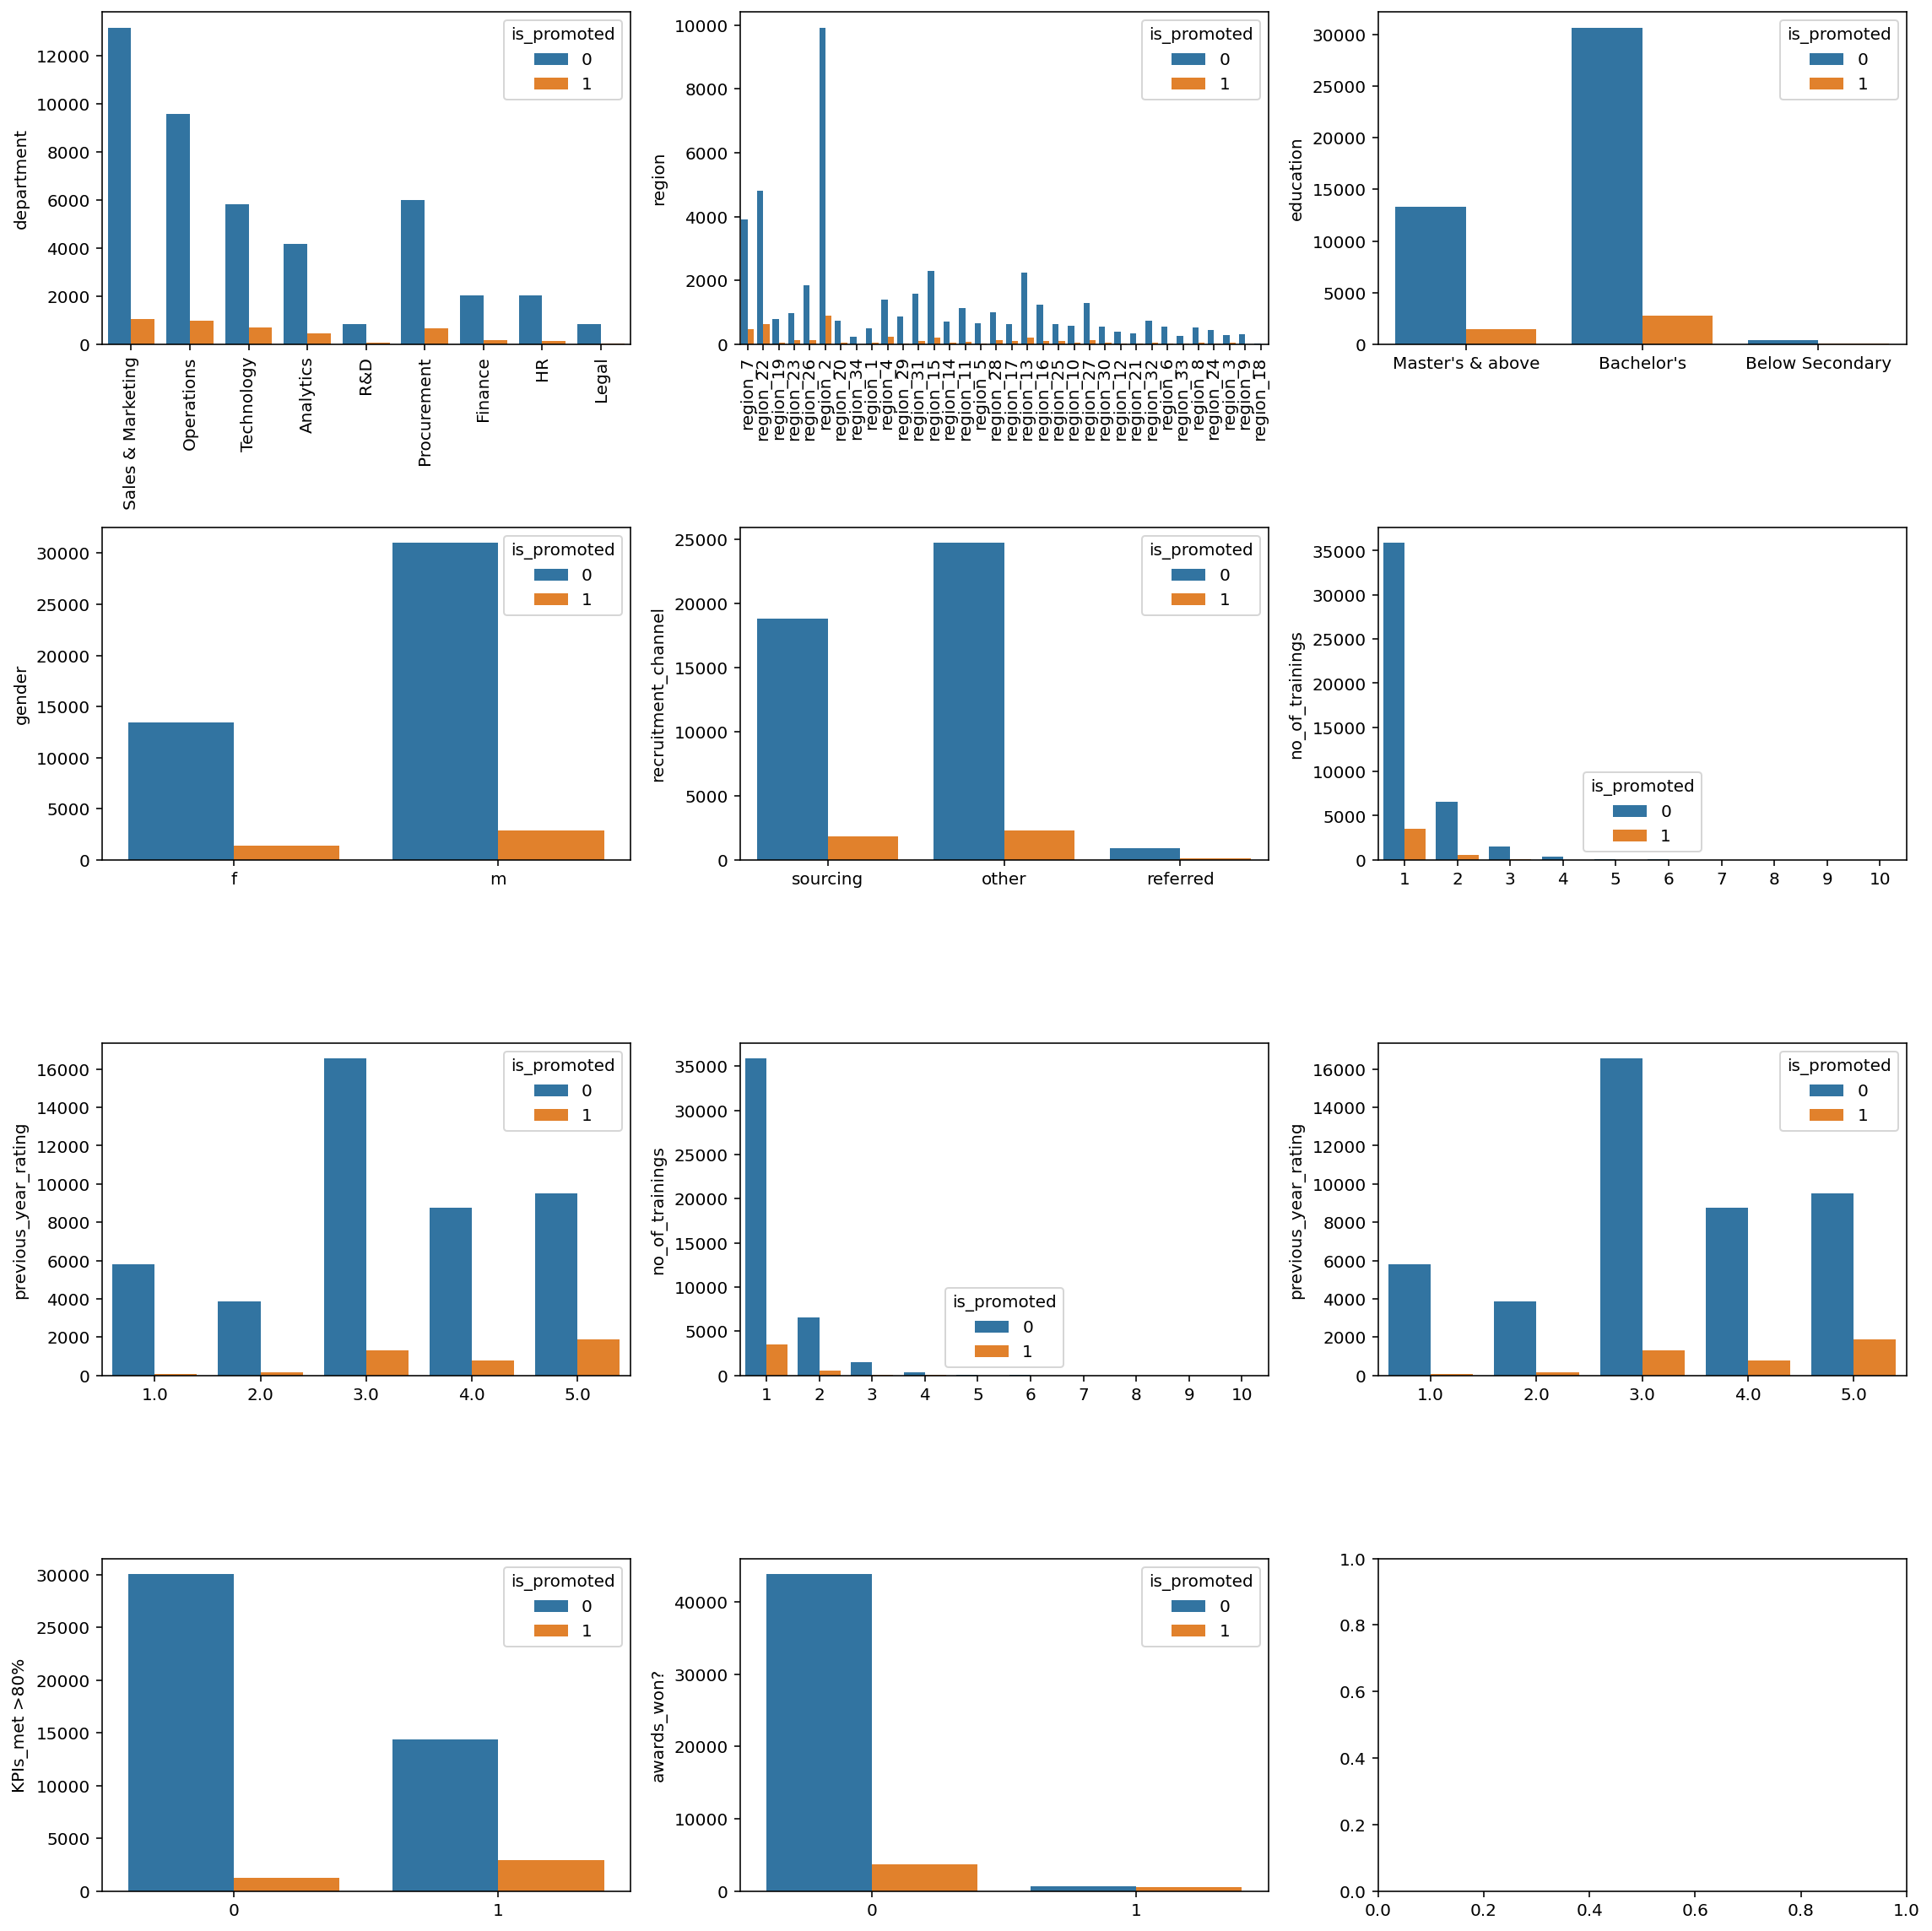

In [105]:
count_plot_features = cat_features + ordinal_features + binary_features
rotation_lst = ['department', 'region']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
for idx, feat in enumerate(count_plot_features):
    ax = axes[int(idx / 3), idx % 3]
    sns.countplot(x=feat, hue="is_promoted", data=data_eda, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)
    if feat in rotation_lst:
        ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout();

### Непрерывные Признаки
Для непрерывных переменных взглянем на boxplot

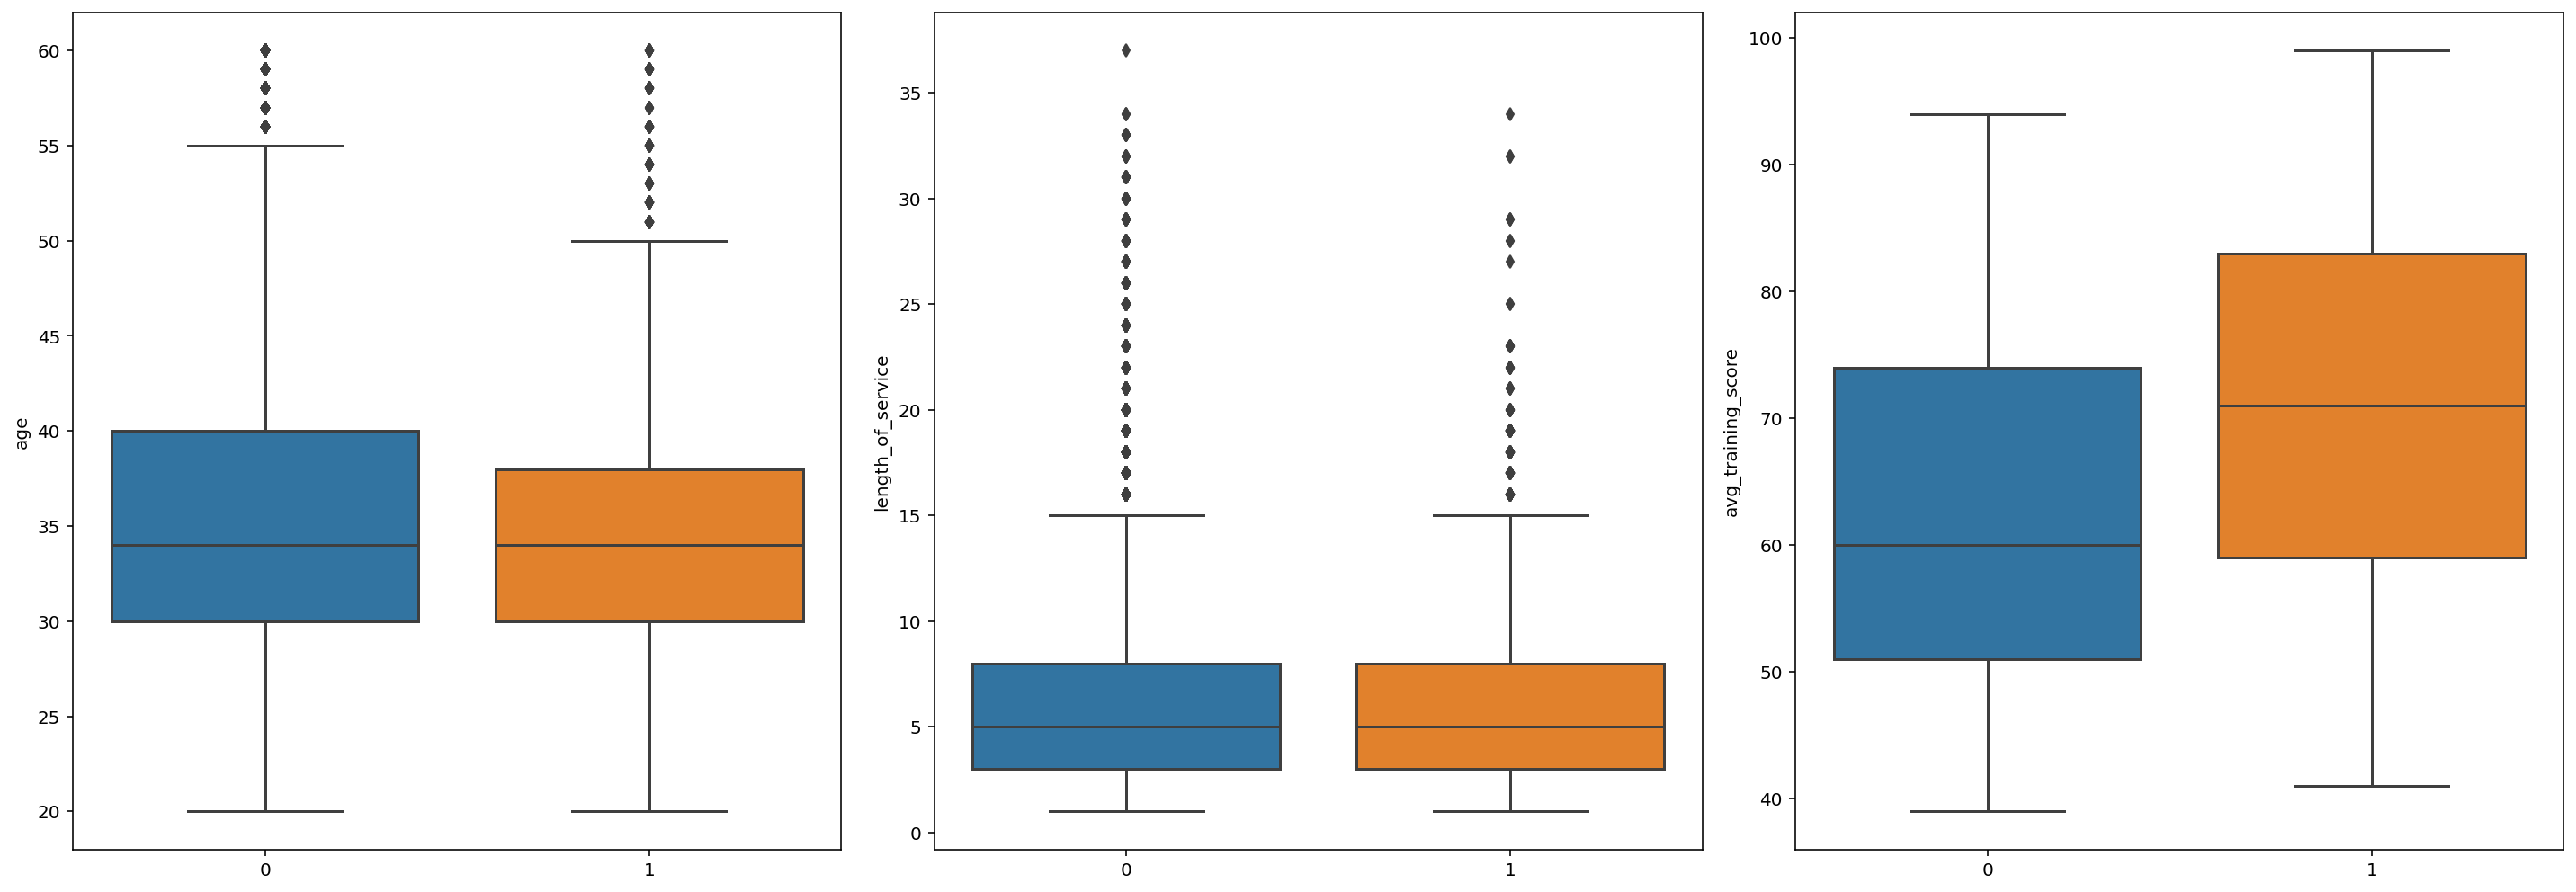

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
for idx, feat in enumerate(num_features):
    ax = axes[idx]
    sns.boxplot(x='is_promoted', y=feat, data=data_eda, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)

fig.tight_layout();

- Можно заметить, что нет никакой разницы в повышении для признаков `age` и `length_of_service`
- Признак `avg_training_score` скорее всего влияет (медианы отличаются друг от друга)

### Baseline
Построим простые модели (LogReg, RandomForest) и сравним их качество

**Признаки**
- Категориальные: отберем все категориальные признаки
- Непрерывные: отберем только `avg_training_score`
- Бинарные: все признаки
- Порядковые: все признаки

**Encoding**
- Категориальные: OneHot
- Бинарные: не кодируем 0/1
- Порядковые: LabelEncoder

**Масштабирование**
- Непрерывные признаки

In [159]:
# определим ML-pipeline
def build_ml_pipeline(model):
    numerical_pipeline = Pipeline(steps=[
        # ('outlier_removal', outlier_remover),
        ('scaler', StandardScaler())
    ])

    binary_pipeline = Pipeline(steps=[
        ('encoder', OneHotEncoder(drop='if_binary'))
    ])

    categorical_pipeline = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    ordinal_pipeline = Pipeline(steps=[
        ('encoder', OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_pipeline, num_features),
            ('binary', binary_pipeline, binary_features),
            ('categorical', categorical_pipeline, cat_features),
            ('ordinal', ordinal_pipeline, ordinal_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ])
    
    return pipeline

In [160]:
# train/test split
X = data_eda.drop(columns='is_promoted')
y = data_eda['is_promoted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

**Logistic Regression**

In [178]:
params = {
    'class_weight': {0:1, 1:10}
}

In [179]:
# train
log_reg_model = LogisticRegression(**params)
log_reg_pipeline = build_ml_pipeline(log_reg_model)

log_reg_pipeline.fit(X_train, y_train)
log_reg_preds = log_reg_pipeline.predict(X_test)
log_reg_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

In [185]:
# estimate
logreg_auc = roc_auc_score(y_test, log_reg_pred_proba)

print(classification_report(y_test, log_reg_preds))
print('LogReg ROC-AUC: ', logreg_auc)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8871
           1       0.80      0.25      0.39       861

    accuracy                           0.93      9732
   macro avg       0.87      0.62      0.67      9732
weighted avg       0.92      0.93      0.91      9732

LogReg ROC-AUC:  0.8761974283349772


**Random Forest**

In [181]:
# train
rf_model = RandomForestClassifier(**params)
rf_pipeline = build_ml_pipeline(rf_model)

rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_preds_proba = rf_pipeline.predict_proba(X_test)[:, 1]

In [184]:
# estimate
rf_auc = roc_auc_score(y_test, rf_preds_proba)
print(classification_report(y_test, rf_preds))
print('RF ROC-AUC: ', rf_auc)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8871
           1       0.80      0.26      0.40       861

    accuracy                           0.93      9732
   macro avg       0.87      0.63      0.68      9732
weighted avg       0.92      0.93      0.91      9732

RF ROC-AUC:  0.8737730806942352


In [186]:
logreg_auc = roc_auc_score(y_test, log_reg_pred_proba)
print('LogReg ROC-AUC: ', logreg_auc)

LogReg ROC-AUC:  0.8761974283349772


### Выводы
Для дальнейшего улучшения качества можно попроовать:
- Посмотреть как влияет заполнение пропусков (небольшой эффект)
- Использовать Feature Selection (средний эффект)
- Поэкспеременитровать с параметрами модели -> потюнить их, особенно для деревянных моделей (средний эффект)
- Так как много категориальных признаков -> сравнить с CatBoost, возможно он даст прирост (средний эффект)
- Можно поэксперементировать с различными парогами принадлжености к классу, тем самым балансируя между precision и recall 

Я, к сожалению, не могу предоставить дальнейшее решение из-за нехватки времени))